# Marvel Superheroes - Group 14

## Group Members
* Simone Facchiano
* Stefano Lacommare
* Jonas Barth

# Index

* [Graph Setup](#Graph-Setup)
    * [Collaborative Graph](#Collaborative-Graph)
    * [Hero-Comic Graph](#Hero-Comic-Graph)
* [Hero Graph Features](#hero-graph-features)
    * [Functionality](#1.-Functionality)
    * [Visualisation](#1.-Visualisation)
* [Find Top Superheroes](#Find-Top-Superheroes)
    * [Functionality](#2.-Functionality)
    * [Visualisation](#2.-Visualisation)
* [Shortest Ordered Route](#shortest-ordered-route)
    * [Functionality](#3-Functionality)
    * [Visualisation](#3-Visualisation)
* [Disconnecting Graphs](#disconnecting-graphs)
    * [Functionality](#4.-Functionality)
    * [Visualisation](#4.-Visualisation)
* [Exctracting Communities](#Extracting-Communities)
    * [Functionality](#5.-Functionality)
    * [Visualisation](#5.-Visualisation)

Turn off the logging messages in the notebook

In [1]:
import logging, sys
logging.disable(sys.maxsize)

# Graph Setup
The graphs are created in the [backend/graph](backend/graph) package. Within this package, there are **two** modules:
- [collaborative](backend/graph/collaborative.py) for creating graphs where heroes are linked to heroes (first graph).
- [hero-comic](backend/graph/hero_comic.py) for creating graphs where heroes are linked to comics (second graph).

Graphs are easily created using the `create_from` function, which can create `networkx` graphs from `.csv` files or `pandas` dataframes. The function returns a tuple of the created graph and its graph type, **collaborative** or **hero-comic**. The function also applies a number of preprocessing steps to the provided data.

## Collaborative Graph

### Preprocessing
The `create_from` function for the collaborative graph applies the following preprocessing steps:

1. remove self loops from the data.
1. strip trailing whitespace and `/` from heroes, e.g. `IRONMAN/TONY STARK/` becomes `IRONMAN/TONY STARK`.
1. replace `SPIDER-MAN/PETER PAR` with `SPIDER-MAN/PETER PARKER`.

### Weight
The collaborative graph is a **weighted** graph, where the weight between the heroes is relative to the **number of collaborations** between them. We have a [weight](backend/graph/weight.py) module with several functions that calculate weights for the edges. The one we chose, will normalise weights into $[0, 1]$ where numbers close to $0$ represent more collaborations between the two heroes that share the edge. 

The equation shows the limit of the weight function that we use. As the number of collaborations $n$ grows to infinity, the weight function will go to $0$ as we subtract the proportion of $n$ over the maximum number of collaborations $max(N)$, where $N$ is the set of all numbers of collaborations.
$$\lim_{n\to\infty} 1 - \frac{n}{max(N) + 1} = 0$$

### Other attributes
In addition to the weight, each edge also has an attribute that specifies the number of collaborations that the two heroes have.

---

We create the graph from the `hero-network.csv` file.

In [2]:
import backend.graph.collaborative as collaborative
import backend.graph.weight as weight

collab_graph, collab_graph_type = collaborative.create_from(data='data/hero-network.csv', weight=weight.max_prop)

## Hero-Comic Graph
The `create_from` function for the hero-comic graph applies the following preprocessing steps:

1. strip trailing whitespace and / from heroes
1. replace `SPIDER-MAN/PETER PARKERKER` with `SPIDER-MAN/PETER PARKER`.

The returned graph is a `networkx` graph object with heroes linked to comics. We create the graph from the `nodes.csv` and `edges.csv` files.

In [3]:
import backend.graph.hero_comic as hero_comic

hero_comic_graph, hero_comic_graph_type = hero_comic.create_from(nodes='data/nodes.csv', edges='data/edges.csv')    

# Controller
We create **one** controller **per graph**. The [controller class](backend/controller.py) has a `run` method that receives:
- names of functionalities
- `top_n` for the top N heroes to consider
- a number of keyword arguments that depend on the functionality. 

The `run` method runs the functionality on the graph that is assigned to the class and returns the result.

In [4]:
from backend import Controller

collab_controller = Controller(collab_graph)
hero_comic_controller = Controller(hero_comic_graph)

# Features

## 1. Functionality
The `features` method will return a [GraphFeatures](backend/describe/graph) instance that contains:
- the graph type of the graph.
- the number of nodes in the graph.
- a set of hero collaboration.
- a list of Comic classes that with information about the number of heroes inside them.
- the density of the graph.
- the distribution of degrees across the graph.
- the average degree in the graph.
- a set of hubs in the graph.
- the mode of the graph, whether it is sparse or dense.

In [5]:
collab_features = collab_controller.run('features', top_n=25, graph_type=collab_graph_type)
hero_comic_features = hero_comic_controller.run('features', top_n=25, graph_type=hero_comic_graph_type)

## 1. Visualisation


SOME BASIC FEATURE:

-->  This network has 25 nodes.
-->  The density of the network is 1.0
-->  Since the density is 1.0, we say that the network is DENSE.
-->  The average degree in the network is 24.0 nodes.

**************************************************

SOME INFO ABOUT THE HUBS:

-->  The Hubs of the network are the following:
['HUMAN TORCH/JOHNNY S', 'INVISIBLE WOMAN/SUE', 'HULK/DR. ROBERT BRUC', 'SUB-MARINER/NAMOR MA', 'WASP/JANET VAN DYNE', 'THOR/DR. DONALD BLAK', 'BEAST/HENRY &HANK& P', 'CAPTAIN AMERICA', 'JAMESON, J. JONAH', 'WATSON-PARKER, MARY', 'FURY, COL. NICHOLAS', 'PROFESSOR X/CHARLES', 'VISION', 'WOLVERINE/LOGAN', 'SCARLET WITCH/WANDA', 'DR. STRANGE/STEPHEN', 'HAWK', 'DAREDEVIL/MATT MURDO', 'IRON MAN/TONY STARK', 'CYCLOPS/SCOTT SUMMER', 'MR. FANTASTIC/REED R', 'STORM/ORORO MUNROE S', 'SPIDER-MAN/PETER PARKER', 'THING/BENJAMIN J. GR', 'ANT-MAN/DR. HENRY J.']

**********************************************************************

SOME INFO ABOUT THE COLLABORATION 

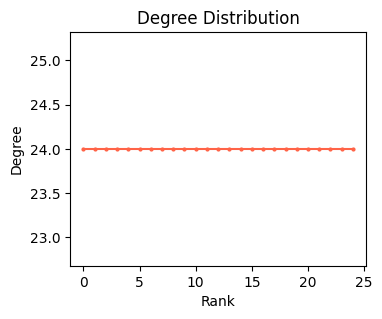

In [6]:
from frontend import visualise_features

visualise_features(collab_features)

# Find Top Superheroes

## 2. Functionality

In [6]:
metric = 'betweenness_centrality'
graph_metrics, node_metrics = collab_controller.run('metrics', top_n=50, node='WOLVERINE/LOGAN', metric=metric)

## 2. Visualisation
In the table below, we see the average betweenness centrality for the top 50 heroes and for WOLVERINE/LOGAN. The value is higher for WOLVERINE/LOGAN.

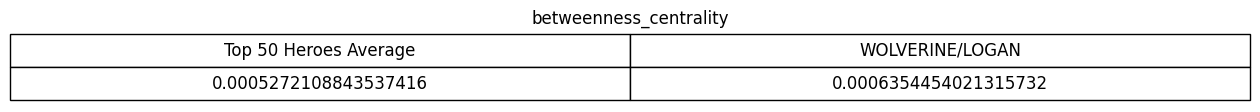

In [7]:
from frontend import metrics

metrics(graph_metrics=graph_metrics, node_metrics=node_metrics, metric=metric)

# Disconnecting Graph

## 4. Functionality
We run the `disconnected_graphs` functionality with the two heroes **SPIDER-MAN/PETER PARKER** and **WOLVERINE/LOGAN**, for the **top 25** heroes. The functionality returns a [Disconnection](backend/domain/disconnection.py) object object that contains:
* the edges that were disconnected
* the cumulative weight of the disconnected edges
* the original graph
* the hero_a
* the hero_b 
* the graph_a that contains hero_a
* the graph_b that contains hero_b

In [6]:
hero_a = 'SPIDER-MAN/PETER PARKER'
hero_b = 'WOLVERINE/LOGAN'

disconnection = collab_controller.run('disconnecting_graphs', top_n=25, hero_a=hero_a, hero_b=hero_b)

## 4. Visualisation

The `disconnected_graph` function from our `frontend` package uses the `disconnection` object to create two `pyvis` graphs and save them as `.html` files. We can then load these files and display them with the help of an `IPython IFrame`.

In [7]:
from frontend import disconnected_graph

message, original_graph_path, disconnected_graph_path = disconnected_graph(disconnection)

### Number of Links 

In [8]:
print(message)

The number of edges that were removed from the original graph is: 24


### The Original Graph
The original graph with the top 25 heroes is a complete graph.

In [9]:
from IPython.display import IFrame

IFrame(src=original_graph_path, width=1000, height=600)

### The Disconnected Graph

Because the original graph with the top 25 heroes is a complete graph (density is equal to 1), when disconnecting them we will end up with a complete graph with 24 heroes and a graph with only a single node.

In [10]:
import networkx as nx
nx.density(disconnection.original_graph)

1.0

In [11]:
from IPython.display import IFrame

IFrame(src=disconnected_graph_path, width=1000, height=600)

# Extracting Communities

## 5. Functionality

In [5]:
hero_1 = 'CAPTAIN AMERICA'
hero_2 = 'IRON MAN/TONY STARK'
comms = collab_controller.run('extract_communities', top_n=25, hero_1=hero_1, hero_2=hero_2)

## 5. Visualisation

The `communities` function from the [frontend](frontend) package generates the visualisation outputs for the extracted communities. It returns:
* a message about the number of removed links
* a table with the two communities
* a path to the original graph
* a path to a graph with the two communities coloured in
* a path to a graph with the communities of the heroes coloured in

Again, the graphs are `.html` files that are generated with the `pyvis` package.

In [10]:
%%capture
from frontend import communities

message, table, comms_original_graph_path, communities_graph_path, comms_final_graph_path = communities(comms)

### Links Removed

In [11]:
print(message)

The number of links that should be removed to have two communities is: 24.


### Communities Table
The table below shows the two generated communities with their heroes. As in [Disconnecting Graph](#Disconnecting-Graph), the split is as **uneven** as it possibly can be, with **one hero** in Community 1 and **the rest** in Community 2. We also observe that the two chosen heroes: **CAPTAIN AMERICA** and **IRON MAN/TONY STARK** ended up in the same community.

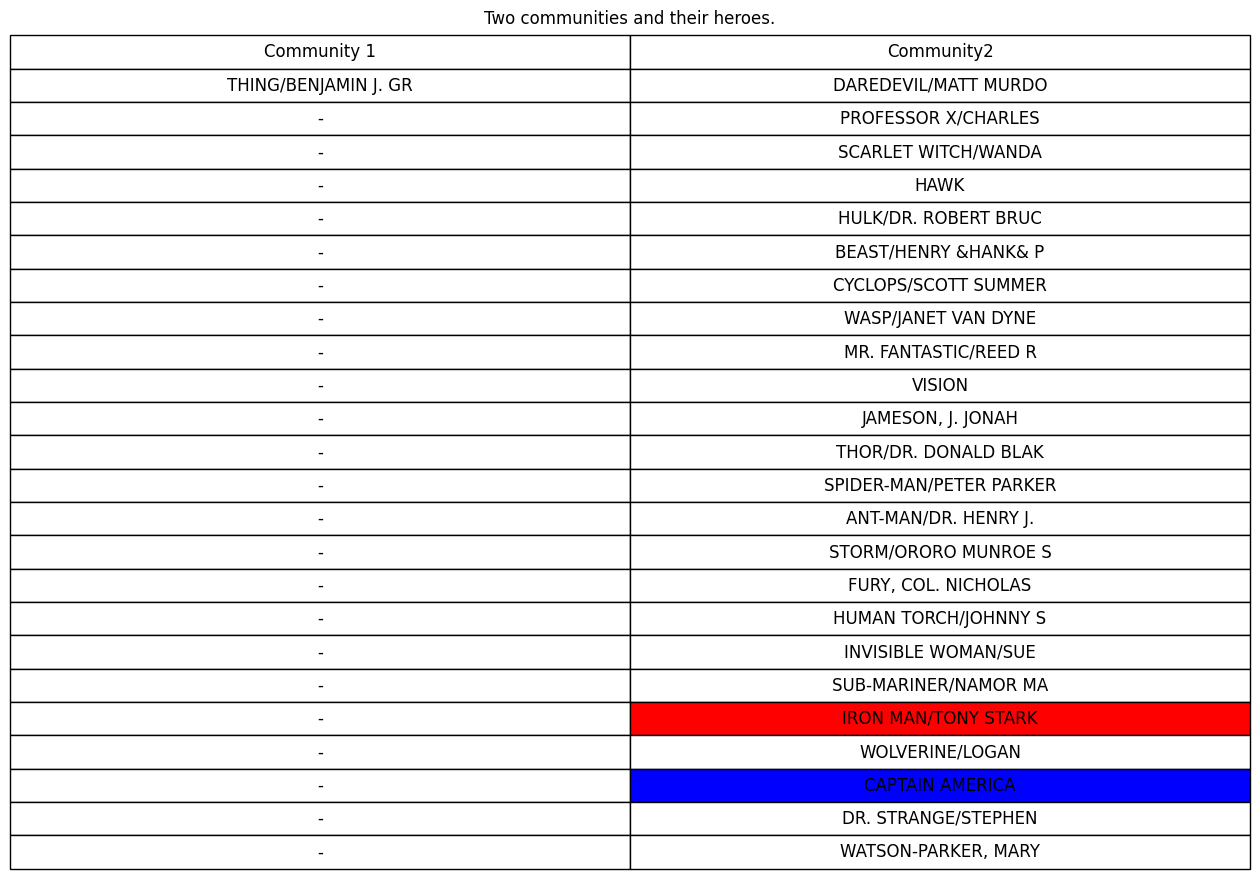

In [12]:
table

### Original Graph
The graph below is the original graph of the top 25 heroes. Again, when scrolling down the frame, there are some settings that can be adjusted, e.g. font size.

In [13]:
IFrame(src=comms_original_graph_path, width=1000, height=600)

### Communities Graph
The graph below shows the two communities: Community 1 (red) and Community (blue). It shows what the communities table already showed, namely the fact that the two communities are extremely imbalanced due to the fact that the graph is so densely connected.

In [14]:
IFrame(src=communities_graph_path, width=1000, height=600)

### Final Graph
The last graph shows the actual communities that hero 1 and hero 2 belong to. The graph can take the following colours:

* green - the community that contains both hero 1 and hero 2.
* blue - the community that contains hero 1 ONLY (not present in this graph because both heroes are in the same community)
* red - the community that contains hero 2 ONLY (not present in this graph because both heroes are in the same community)
* yellow - the community that contains neither hero 1 nor hero 2.

In [15]:
IFrame(src=comms_final_graph_path, width=1000, height=600)